In [1]:
import pandas as pd

df = pd.read_csv('Data/2025_02_28_M9_combined.csv')
df.drop(columns=['Pred_RFP'], inplace=True)
df.dropna(subset=['Sequence'], inplace=True)
df.head()

,Strain,Sequence,Rep,Date,Abs590,Ex550Em630,Rel_RFP
2,pLac,AATACTAGAGGTCTTCCGACTTTACACTTTATGCTTCCGGCTCGTA...,Rep1,2024_07_03,1.124517,143364.5,1.274899e+05
3,pLac,AATACTAGAGGTCTTCCGACTTTACACTTTATGCTTCCGGCTCGTA...,Rep2,2024_07_03,1.172258,154328.5,1.316506e+05
4,Low,AATACTAGAGGTCTTCCGACTTGACACTATTTCCTATTTCTCTTAT...,Rep1,2024_07_03,1.097638,1665030.0,1.516921e+06
5,Low,AATACTAGAGGTCTTCCGACTTGACACTATTTCCTATTTCTCTTAT...,Rep2,2024_07_03,1.179940,1871351.5,1.585972e+06
6,Medium,AATACTAGAGGTCTTCCGACAAGACGCTATTTCCTATTTCTCTTAT...,Rep1,2024_07_03,0.589719,182165.5,3.089020e+05


In [2]:
df = df.pivot(index=['Strain', 'Sequence'], columns='Rep', values='Rel_RFP').reset_index()
df.columns.name = None
df.rename(columns={'Rep1': 'Rel_RFP_1', 'Rep2': 'Rel_RFP_2'}, inplace=True)

df.head()

,Strain,Sequence,Rel_RFP_1,Rel_RFP_2
0,High,AATACTAGAGGTCTTCCGACCCCCTATTTCCTATTTCTGTAGTCAT...,7.261783e+04,-3.567322e+04
1,Low,AATACTAGAGGTCTTCCGACTTGACACTATTTCCTATTTCTCTTAT...,1.516921e+06,1.585972e+06
2,Medium,AATACTAGAGGTCTTCCGACAAGACGCTATTTCCTATTTCTCTTAT...,3.089020e+05,3.305197e+05
3,OsmY,ATACTAGAGGTCTTCCGACCCCGAGCGGTTTCAAAATTGTGATCTA...,2.216222e+05,2.151740e+05
4,OsmY_C13A,TACTAGAGGTCTTCCGACCCCGAGCGGTTTCAAAATTGTGATATAT...,1.884835e+05,8.323190e+04


In [18]:
import numpy as np

def padded_one_hot_encode(sequence):
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1], '0': [0, 0, 0, 0]}
    return np.array([mapping[nucleotide.upper()] for nucleotide in sequence])

df['Preprocessed'] = df['Sequence'].apply(lambda x: padded_one_hot_encode(x.zfill(150) if x else '0' * 150))

df['Rel_RFP'] = df[['Rel_RFP_1', 'Rel_RFP_2']].mean(axis=1)

df.head()

,Strain,Sequence,Rel_RFP_1,Rel_RFP_2,Preprocessed,CNN_5_0_Pred,CNN_6_1_2_Pred,CNN_7_0_Pred,Rel_RFP
0,High,AATACTAGAGGTCTTCCGACCCCCTATTTCCTATTTCTGTAGTCAT...,7.261783e+04,-3.567322e+04,"[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...",0.734119,0.294333,0.312739,1.847231e+04
1,Low,AATACTAGAGGTCTTCCGACTTGACACTATTTCCTATTTCTCTTAT...,1.516921e+06,1.585972e+06,"[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...",0.502851,0.419188,0.476804,1.551447e+06
2,Medium,AATACTAGAGGTCTTCCGACAAGACGCTATTTCCTATTTCTCTTAT...,3.089020e+05,3.305197e+05,"[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...",0.617678,0.365856,0.449131,3.197109e+05
3,OsmY,ATACTAGAGGTCTTCCGACCCCGAGCGGTTTCAAAATTGTGATCTA...,2.216222e+05,2.151740e+05,"[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...",0.660137,0.409059,0.325157,2.183981e+05
4,OsmY_C13A,TACTAGAGGTCTTCCGACCCCGAGCGGTTTCAAAATTGTGATATAT...,1.884835e+05,8.323190e+04,"[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...",0.623739,0.397303,0.371531,1.358577e+05


In [22]:
from keras.models import load_model # type: ignore

CNN_5_0 = load_model('Models/CNN_5_0.keras')
CNN_5_1 = load_model('Models/CNN_5_1.keras')
CNN_6_1_2 = load_model('Models/CNN_6_1_2.keras')
CNN_7_0 = load_model('Models/CNN_7_0.keras')

df['CNN_5_0_Pred'] = 1 - CNN_5_0.predict(np.array(list(df['Preprocessed'])))
df['CNN_5_1_Pred'] = CNN_5_1.predict(np.array(list(df['Preprocessed'])))
df['CNN_6_1_2_Pred'] = CNN_6_1_2.predict(np.array(list(df['Preprocessed'])))
df['CNN_7_0_Pred'] = CNN_7_0.predict(np.array(list(df['Preprocessed'])))


c:\Users\rsore\anaconda3\envs\TX_prediction\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 34 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


In [37]:
df[['Strain', 'Rel_RFP_1', 'CNN_5_0_Pred', 'CNN_5_1_Pred', 'CNN_6_1_2_Pred', 'CNN_7_0_Pred']].sort_values(by='Rel_RFP_1').head(None)

,Strain,Rel_RFP_1,CNN_5_0_Pred,CNN_5_1_Pred,CNN_6_1_2_Pred,CNN_7_0_Pred
6,P533A,-8.803350e+03,0.315706,0.438758,0.379630,0.358038
0,High,7.261783e+04,0.265881,0.224094,0.294333,0.312739
16,pLac,1.274899e+05,0.474648,0.377289,0.337836,0.427421
4,OsmY_C13A,1.884835e+05,0.376261,0.466926,0.397303,0.371531
3,OsmY,2.216222e+05,0.339863,0.435567,0.409059,0.325157
7,neg,2.624810e+05,0.408571,0.474338,0.337590,0.300075
2,Medium,3.089020e+05,0.382322,0.259126,0.365856,0.449131
12,p500,4.526420e+05,0.363854,0.402017,0.499743,0.522043
9,p125,5.207380e+05,0.248550,0.398812,0.124920,0.308300
11,p375,5.368120e+05,0.274400,0.327754,0.374801,0.348918


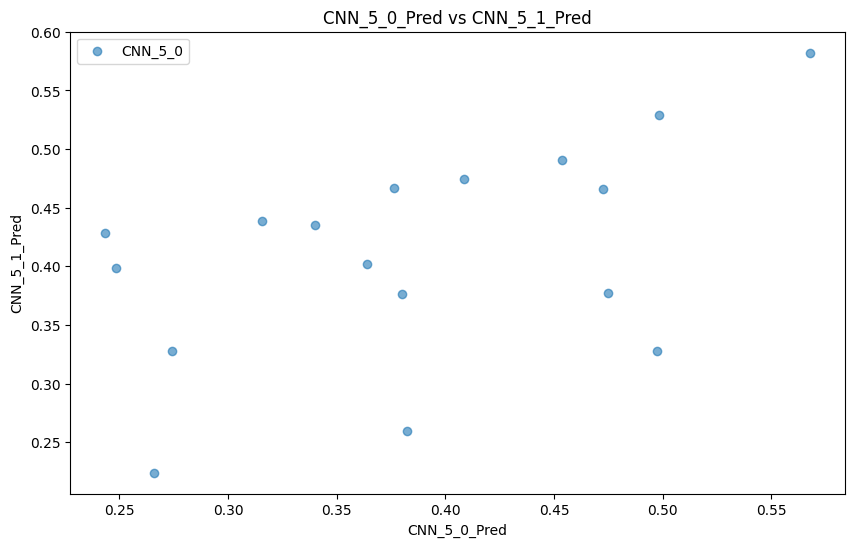

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.scatter(df['CNN_5_0_Pred'], df['CNN_5_1_Pred'], label='CNN_5_0', alpha=0.6)
plt.xlabel('CNN_5_0_Pred')
plt.ylabel('CNN_5_1_Pred')
plt.title('CNN_5_0_Pred vs CNN_5_1_Pred')
plt.legend()
plt.show()

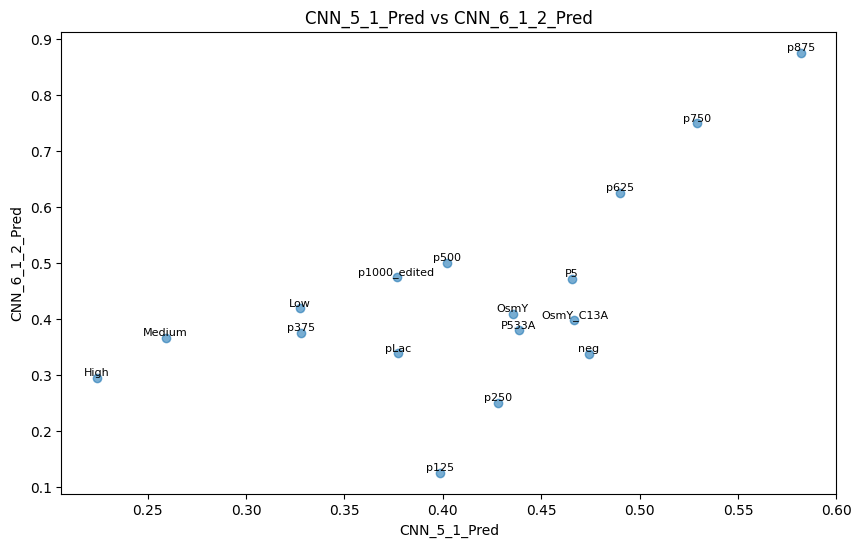

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.scatter(df['CNN_5_1_Pred'], df['CNN_6_1_2_Pred'], alpha=0.6)
plt.xlabel('CNN_5_1_Pred')
plt.ylabel('CNN_6_1_2_Pred')
plt.title('CNN_5_1_Pred vs CNN_6_1_2_Pred')

for row in df.iterrows():
    plt.text(row[1]['CNN_5_1_Pred'], row[1]['CNN_6_1_2_Pred'], row[1]['Strain'], fontsize=8, ha='center', va='bottom')

plt.show()

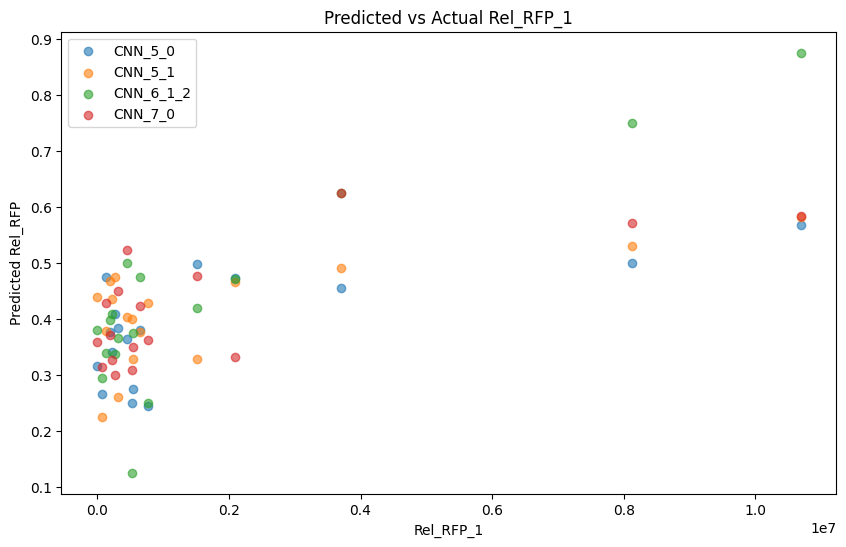

In [43]:
import matplotlib.pyplot as plt

# graph the predictions vs Rel_RFP_1

# filtered_df = df[df['Rel_RFP_1'] >= df[df['Strain'] == 'p250']['Rel_RFP_1'].min()]
filtered_df = df

plt.figure(figsize=(10, 6))

plt.scatter(filtered_df['Rel_RFP_1'], filtered_df['CNN_5_0_Pred'], label='CNN_5_0', alpha=0.6)
plt.scatter(filtered_df['Rel_RFP_1'], filtered_df['CNN_5_1_Pred'], label='CNN_5_1', alpha=0.6)
plt.scatter(filtered_df['Rel_RFP_1'], filtered_df['CNN_6_1_2_Pred'], label='CNN_6_1_2', alpha=0.6)
plt.scatter(filtered_df['Rel_RFP_1'], filtered_df['CNN_7_0_Pred'], label='CNN_7_0', alpha=0.6)
plt.xlabel('Rel_RFP_1')
plt.ylabel('Predicted Rel_RFP')
plt.title('Predicted vs Actual Rel_RFP_1')
plt.legend()
plt.show()


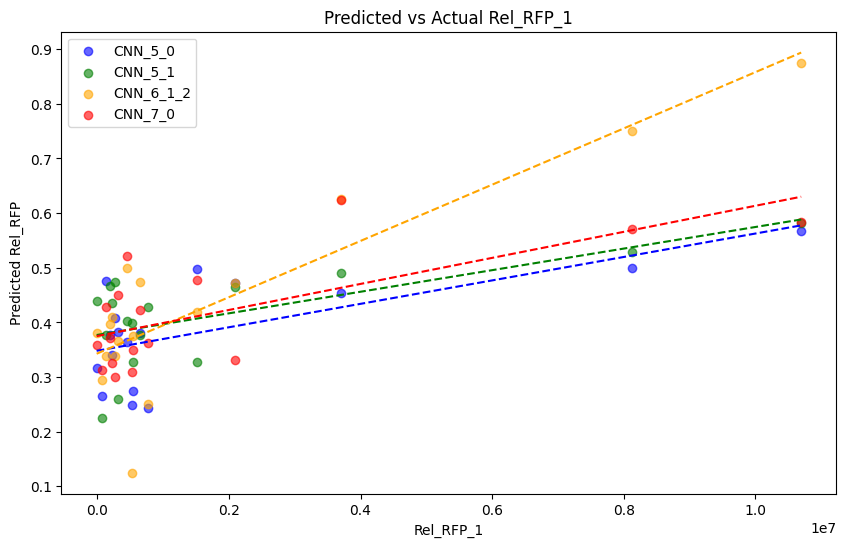

In [28]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Helper function to plot line of best fit
def plot_with_fit(x, y, label, color):
    plt.scatter(x, y, label=label, alpha=0.6, color=color)
    # Line of best fit
    coeffs = np.polyfit(x, y, 1)
    fit_line = np.poly1d(coeffs)
    plt.plot(np.sort(x), fit_line(np.sort(x)), linestyle='--', color=color)

# Define colors for consistency
colors = ['blue', 'green', 'orange', 'red']

plot_with_fit(df['Rel_RFP_1'], df['CNN_5_0_Pred'], 'CNN_5_0', colors[0])
plot_with_fit(df['Rel_RFP_1'], df['CNN_5_1_Pred'], 'CNN_5_1', colors[1])
plot_with_fit(df['Rel_RFP_1'], df['CNN_6_1_2_Pred'], 'CNN_6_1_2', colors[2])
plot_with_fit(df['Rel_RFP_1'], df['CNN_7_0_Pred'], 'CNN_7_0', colors[3])

plt.xlabel('Rel_RFP_1')
plt.ylabel('Predicted Rel_RFP')
plt.title('Predicted vs Actual Rel_RFP_1')
plt.legend()
plt.show()
